In [292]:
import pandas as pd
import numpy as np
import os
import requests
from bs4 import BeautifulSoup
from functools import reduce
from unidecode import unidecode
import re
from datetime import datetime

# Configuration Variables 

In [3]:
def get_player_statistics(stat_links, df_order):
    for nations in STAT_LINKS:
        for team in STAT_LINKS[nations]:
            df_list = pd.read_html(STAT_LINKS[nations][team], header=1)
            for i, df in enumerate(df_list):
                if not os.path.isdir(f"{nations}/player_stats/{team}/"):
                    os.makedirs(f"{nations}/player_stats/{team}/")
                df.to_csv(f"{nations}/player_stats/{team}/{df_order[i]}.csv", index=False)

In [ ]:
get_player_statistics(STAT_LINKS, DF_ORDER)

In [ ]:
def get_player_info(INFO_LINKS):
    
    for nation in INFO_LINKS:
        for team in INFO_LINKS[nation]:

        # Get team name.
            team_name = team.split("/")[3]

            headers = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/47.0.2526.106 Safari/537.36'}
            page = team
            pageTree = requests.get(page, headers=headers)
            pageSoup = BeautifulSoup(pageTree.content, 'html.parser')

            # Acquire player names, prices and positions. 
            names = []
            positions = []
            tables= pageSoup.find_all('table', class_='inline-table')
            for table in tables:
                rows = table.find_all('tr')
                name = rows[0].text.strip()
                position = rows[1].text.strip()
                names.append(name)
                positions.append(position)

            player_prices = pageSoup.find_all(class_='rechts hauptlink')
            prices = []
            for price in player_prices:
                price = price.text.strip()
                prices.append(price)

            # Store in info dataframe.
            info = pd.DataFrame({'name': names, 'price': prices, 'position':positions})

            # Custom logic to acquire dob, nationality, height, foot, join_date, and contract_expiration.
            data_rows = []
            tables= pageSoup.find_all('table', class_='items')
            for table in tables:
                rows = table.find_all('td', {"class": "zentriert"})
                for i in range(len(rows)):
                    data_rows.append(rows[i])


            general = [data_rows[i:i + 8] for i in range(0, len(data_rows), 8)]
            overall = []
            for g in general:
                overall.append(dict(
                  dob = g[1].text.strip(),
                  nationality = g[2].img['alt'],
                  height = g[3].text.strip(),
                  foot = g[4].text.strip(),
                  join_date = g[5].text.strip(),
                  contract_expiration = g[7].text.strip(), 
              )
              )
            # Create info2 dataframe with additional information.
            info2 = pd.DataFrame(overall)

            # Concat info with info2 to combine information.
            overall = pd.concat([info, info2], axis=1)

            if not os.path.isdir(f"{nation}/player_info"):
                  os.makedirs(f"{nation}/player_info")

            # Export dataframe to nation directory.
            overall.to_csv(f"{nation}/player_info/{team_name}.csv", index=False)

In [ ]:
get_player_info(INFO_LINKS)

In [1]:
def clean_up_defensive_actions(df):
    df = df.iloc[:-2]
    
    df.drop(columns=[
        '90s',
        'Matches',
        'Nation',
        'Pos',
        'Age',
        'Tkl.1',
        'Att',
        'Tkl%',
        'Lost',
        'Blocks',
        'Tkl+Int',
        'Pass'
    ], inplace=True)
    
    df.rename(columns={
        'Tkl': 'tackles',
        'TklW': 'tackles_won',
        'Def 3rd': 'defensive_third_tackles',
        'Mid 3rd': 'midfield_tackles',
        'Att 3rd': 'attacking_third_tackles',
        'Sh': 'shots_blocked',
        'Pass': 'passes_blocked',
        'Int': 'interceptions',
        'Clr': 'clearances',
        'Err': 'errors_leading_to_goal'
    }, inplace=True)
    
    return df

In [ ]:
def clean_up_goal_and_shot(df):
    df = df.iloc[:-2]
    
    df.drop(columns=[
        '90s',
        'Matches',
        'Nation',
        'Pos',
        'Age',
        'SCA90',
        'GCA90',
    ], inplace=True)
    
    df.rename(columns={
        'SCA': 'shot_creating_actions',
        'PassLive': 'sca_live_passes',
        'PassDead': 'sca_dead_passes',
        'TO': 'sca_take_ons',
        'Sh': 'sca_shots',
        'Fld': 'sca_fouls_drawn',
        'Def': 'sca_defensive_actions',
        'GCA': 'goal_creation_actions',
        'PassLive.1': 'gca_live_passes',
        'PassDead.1': 'gca_dead_passes',
        'TO.1': 'gca_take_ons',
        'Sh.1': 'gca_shots',
        'Fld.1': 'gca_fouls_drawn',
        'Def.1': 'gca_defensive_actions',
    }, inplace=True)
    
    return df

In [ ]:
def clean_up_miscellaneous(df):
    df = df.iloc[:-2]
    
    df.drop(columns=[
        '90s',
        'Matches',
        'Nation',
        'Pos',
        'Age',
        '2CrdY',
        'Crs',
        'Int',
        'TklW',
        'Won%',
    ], inplace=True)
    
    df.rename(columns={
        'CrdY': 'yellow_cards',
        'CrdR': 'red_cards',
        'Fls': 'fouls',
        'Fld': 'fouls_drawn',
        'Off': 'offsides',
        'Fls': 'fouls',
        'Fld': 'fouls_drawn',
        'Off': 'offsides',
        'PKwon': 'penalties_won',
        'PKcon': 'penalties_conceded',
        'OG': 'own_goals',
        'Recov': 'ball_recoveries',
        'Won': 'aerial_duels_won',
        'Lost': 'aerial_duels_lost',
    }, inplace=True)
    
    return df

In [ ]:
def clean_up_passing(df):
    df = df.iloc[:-2]
    
    df.rename(columns={
        'Cmp.1': 'short_passes_completed',
        'Att.1': 'short_passes_attempted',
        'Cmp.2': 'medium_passes_completed',
        'Att.2': 'medium_passes_attempted',
        'Cmp.3': 'long_passes_completed',
        'Att.3': 'long_passes_attempted',
        'Ast': 'assists',
        'xA': 'expected_assists',
        'KP': 'key_passes',
        '1/3': 'passes_into_final_third',
        'PPA': 'passes_into_penalty_box',
        'CrsPA': 'crosses_into_penalty_area',
        'PrgP': 'progressive_passes',
    }, inplace=True)
   
    df.drop(columns=[
        '90s',
        'Matches',
        'Nation',
        'Pos',
        'Age',
        'Cmp',
        'Att',
        'Cmp%',
        'TotDist',
        'PrgDist',
        'Cmp%.1',
        'Cmp%.2',
        'Cmp%.3',
        'xAG',
        'A-xAG',
    ], inplace=True)
    
    return df

In [ ]:
def clean_up_playing_time(df):
    df = df.iloc[:-2]
    
    df = df[['Player', 'Min', 'MP', 'Starts']]
    
    df.rename(columns={
        'Min': 'minutes_played',
        'MP': 'matches_played',
        'Starts': 'matches_started',
    }, inplace=True)
    
    return df

In [ ]:
def clean_up_possession(df):
    df = df.iloc[:-2]
    
    df.drop(columns=[
        '90s',
        'Matches',
        'Nation',
        'Pos',
        'Age',
        'Touches',
        'Live',
        'Succ%',
        'Tkld%',
        'Rec',
        'PrgR',
    ], inplace=True)
    
    df.rename(columns={
        'Def Pen': 'touches_penalty_area_defending',
        'Def 3rd': 'touches_defensive_third',
        'Mid 3rd': 'touches_middle_third',
        'Att 3rd': 'touches_attacking_third',
        'Att Pen': 'touches_penalty_area_attacking',
        'Att': 'attempted_take_ons',
        'Succ': 'successful_take_ons',
        'Tkld': 'tackled_take_ons',
        'Carries': 'carries',
        'TotDist': 'total_carrying_distance',
        'PrgDist': 'progressive_carrying_distance',
        'PrgC': 'progressive_carries',
        '1/3': 'carries_into_final_third',
        'CPA': 'carries_into_penalty_area',
        'Mis': 'carry_miscontrols',
        'Dis': 'carry_dispossessions',
    }, inplace=True)
    
    return df

In [ ]:
def clean_up_shooting(df):
    df = df.iloc[:-2]
    
    df.drop(columns=[
        '90s',
        'Matches',
        'Nation',
        'Pos',
        'Age',
        'SoT%',
        'Sh/90',
        'SoT/90',
        'G/SoT',
        'npxG',
        'npxG/Sh',
        'G-xG',
        'np:G-xG',
    ], inplace=True)
    
    df.rename(columns={
        'Gls': 'goals',
        'Sh': 'total_shots',
        'SoT': 'shots_on_target',
        'G/Sh': 'goals_per_shot',
        'Dist': 'average_shot_distance',
        'FK': 'freekick_shots',
        'PK': 'penalty_kicks_converted',
        'PKatt': 'penalty_kicks_attempted',
    }, inplace=True)
    
    return df

In [ ]:
def clean_up_statistic_dataframes(directory):
    
    files = [
        ("playing_time.csv", clean_up_playing_time),
        ("defensive_actions.csv", clean_up_defensive_actions),
        ("goal_and_shot_creation.csv", clean_up_goal_and_shot),
        ("miscellaneous_tasks.csv", clean_up_miscellaneous),
        ("passing.csv", clean_up_passing),
        ("possession.csv", clean_up_possession),
        ("shooting.csv", clean_up_shooting),
    ]
    
    dfs = []
    for file, clean_func in files:
        df = pd.read_csv(f"{directory}/{file}")
        df = clean_func(df)
        dfs.append(df)
    
    df_merged = pd.concat(dfs, axis=1)
    
    return df_merged


In [ ]:
def get_statistics_df(NATIONS):
    for nation in NATIONS:
        rootdir = f'{nation}/player_stats/'
        dfs = []
        for i, file in enumerate(os.listdir(rootdir)):
            d = os.path.join(rootdir, file)
            if ".ipynb_checkpoints" in d:
                continue
            dfs.append(clean_up_statistic_dataframes(d))
        result_df = pd.concat(dfs, ignore_index=True)
        result_df = result_df.loc[:, ~result_df.columns.duplicated()]

        result_df.to_csv(f"{nation}/overall_player_stats.csv", index=False)

In [ ]:
get_statistics_df(NATIONS)

In [ ]:
def get_information_df(NATIONS):
    for nation in NATIONS:
        directory = f'{nation}/player_info'

        csv_files = [f for f in os.listdir(directory) if f.endswith('.csv')]

        dfs = []

        for csv_file in csv_files:
            df = pd.read_csv(os.path.join(directory, csv_file))
            dfs.append(df)

        merged_df = pd.concat(dfs, ignore_index=True)

        merged_df.to_csv(f"{nation}/player_info.csv", index=False)

In [ ]:
get_information_df(NATIONS)

In [ ]:
def compile_nation_df(NATIONS):
    for nation in NATIONS:

        df1 = pd.read_csv(f"{nation}/player_info.csv")
        df2 = pd.read_csv(f"{nation}/overall_player_stats.csv")

        df1["normalized_named"] = df1["name"].apply(unidecode)
        df2["normalized_named"] = df2["Player"].apply(unidecode)

        merged_df = pd.merge(df1, df2, on="normalized_named", how="inner")
        merged_df.drop(columns=["normalized_named", "Player"], axis=1, inplace=True)
        
        if not os.path.isdir(f"finalized_nation_datasets"):
                  os.makedirs(f"finalized_nation_datasets")
        
        merged_df.to_csv(f"finalized_nation_datasets/{nation}_dataset.csv", index=False)

In [ ]:
compile_nation_df(NATIONS)

In [ ]:
def get_general_dataset():
    directory = f'finalized_nation_datasets/'

    csv_files = [f for f in os.listdir(directory) if f.endswith('.csv')]

    dfs = []

    for csv_file in csv_files:
        df = pd.read_csv(os.path.join(directory, csv_file))
        dfs.append(df)

    merged_df = pd.concat(dfs, ignore_index=True)

    merged_df.to_csv(f"player_dataset.csv", index=False)

In [ ]:
get_general_dataset()

In [300]:
df = pd.read_csv('player_dataset.csv')

## Data Cleaning 

In [301]:
df.count()

name                       3280
price                      3280
position                   3280
dob                        3280
nationality                3280
                           ... 
average_shot_distance      2545
freekick_shots             3011
penalty_kicks_converted    3015
penalty_kicks_attempted    3015
xG                         3011
Length: 84, dtype: int64

### Converting/Fixing Price

In [302]:
df['price'] = df['price'].str.replace('.', '')
df['price'] = df['price'].str.replace('€', '')
df['price'] = df['price'].str.replace('m', '0000').str.replace('k', '000')
df['price'] = df['price'].astype('double', errors='ignore')
df = df[df['price'] != '-'].reset_index(drop=True)

/var/folders/tf/28wdj00j4h1_5_yq0wc9jwm40000gn/T/ipykernel_23304/1752925445.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df['price'] = df['price'].str.replace('.', '')


### Deleting Goalkeepers

In [303]:
df = df[df['position'] != 'Goalkeeper'].reset_index(drop=True)

### Simplifying Positions

In [305]:
position_mappings = {'Centre-Back': 'Defender', 'Left-Back': 'Defender', 'Right-Back': 'Defender',
                  'Attacking Midfield': 'Midfielder', 'Central Midfield': 'Midfielder', 'Central Midfielder': 'Midfielder', 'Defensive Midfield': 'Midfielder', 'Left Midfield': 'Midfielder', 'Right Midfield': 'Midfielder',
                  'Left Winger': 'Attacker', 'Right Winger': 'Attacker', 'Centre-Forward': 'Attacker', 'Second Striker': 'Attacker'}

# Map positions to roles using the position_roles dictionary
df['position'] = df['position'].map(position_mappings)


In [297]:
df['position'].value_counts()

Series([], Name: position, dtype: int64)

### Extracting Age from DOB

In [307]:
def extract_age(date_str):
    return int(re.search(r'\((\d+)\)', date_str).group(1))

In [308]:
df['dob'] = df['dob'].apply(extract_age)

In [309]:
df = df.rename(columns={'dob':'age'})

### Date Conversions

In [310]:
def date_conversion(x):
    if x == '-':
        return
    else:
        return datetime.strptime(x, '%b %d, %Y')

In [311]:
df['join_date'] = df['join_date'].apply(date_conversion)
df['contract_expiration'] = df['contract_expiration'].apply(date_conversion)

### Converting Height to Number

In [312]:
def transform_height(height):
    if height == '-':
        return
    else:
        height_m = float(height.replace(',', '.')[:-1])
        height_cm = height_m * 100
        return height_cm

In [313]:
df['height'] = df['height'].apply(transform_height)

### Deleting Players with No Playing Time

In [314]:
df = df[~df['minutes_played'].isna()].reset_index(drop=True)

### REFINEMENT

Dropped List (simplified):
- matches played
- matches started
- tackles
- tackles won
- defensive / midfield / attacking third tackles
- interceptions
- clearances
- shots_blocked
- sca_live_passes
- sca_dead_passes
- sca_take-ons
- sca_shots
- sca_fouls_drawn
- sca_defensive_actions
- shot_creating_actions
- gca_live_passes
- gca_dead_passes
- gca_take-ons
- gca_shots
- gca_fouls_drawn
- gca_defensive_actions
- goal_creation_actions
- yellow_cards
- red_cards
- fouls
- short_passes_attempted
- short_passes_completed
- medium_passes_attempted
- medium_passes_completed
- long_passes_attempted
- long_passes_completed
- assists
- passes_into_final_third
- passes_into_penalty_box
- crosses_into_penalty_area
- progressive_passes
- touches_penalty_area_defending
- touches_defensive_third
- touches_middle_third
- touches_attacking_third
- touches_penalty_area_attacking

Dropped List (waitlist):

- errors_leading_to_goal
- offsides
- penalties_won
- penalties_conceded
- own_goals
- fouls_drawn
- expected_assists
- key_passes

In [315]:
df[df['name'] == 'Jude Bellingham']

,name,price,position,age,nationality,height,foot,join_date,contract_expiration,minutes_played,...,carry_dispossessions,goals,total_shots,shots_on_target,goals_per_shot,average_shot_distance,freekick_shots,penalty_kicks_converted,penalty_kicks_attempted,xG
251,Jude Bellingham,110000000,Midfielder,19,England,186.0,right,2020-07-23,2025-06-30,2075.0,...,46.0,4.0,46.0,16.0,0.09,17.1,2.0,0.0,0.0,4.9


In [316]:
players = df.copy()

In [355]:
df.to_csv("old.csv", index=False)

# Playing Time

Features Dropped:
    
- matches_played
- matches_started 

Turned into tackle success rate.

In [317]:
players = players.drop(['matches_started','matches_played'], axis=1)

Ideas
- rates instead of figures
- additional / removal of features

# Tackles

Features Dropped:
    
- tackles
- tackles won
- defensive / midfield / attacking third tackles

Turned into tackles won per minutes played. 

In [318]:
players['tackles_won_per_mp'] = players['tackles_won'] / players['minutes_played']

In [319]:
players.drop(['defensive_third_tackles', 'midfield_tackles', 'attacking_third_tackles', 'tackles_won', 'tackles'], axis=1, inplace=True)

# Defensive Actions

Features Dropped:
    
- interceptions
- clearances
- shots_blocked
- ball_recoveries

Turned into defensive_actions_per_mp

In [320]:
players['defensive_actions_per_mp'] = (players['interceptions'] + players['clearances'] + players['shots_blocked'] + players['ball_recoveries']) / players['minutes_played']

In [321]:
players.drop(['interceptions', 'clearances', 'shots_blocked', 'ball_recoveries'], axis=1, inplace=True)

# Miscellaneous

Features Dropped:
    
- errors_leading_to_goal
- offsides
- penalties_won
- penalties_conceded
- fouls_drawn

#### There are questions over the impact that these features will have in our regression model, therefore they are dropped.

In [322]:
players.drop([
    'errors_leading_to_goal',
    'offsides',
    'penalties_won', 
    'penalties_conceded',
    'fouls_drawn',
    'own_goals'
    ], axis=1, inplace=True)

# Shot-Creating Actions

Features Dropped:
    
- sca_live_passes
- sca_dead_passes
- sca_take-ons
- sca_shots
- sca_fouls_drawn
- sca_defensive_actions
- shot_creating_actions

Turned into sca_per_mp. (shot-creating-actions per minutes played)

#### The overall 'shot-creating-actions / minutes played will represent this feature.

In [323]:
players['sca_per_mp'] = players['shot_creating_actions'] / players['minutes_played']

In [324]:
players.drop([
    'sca_live_passes',
    'sca_dead_passes',
    'sca_take_ons',
    'sca_fouls_drawn',
    'sca_defensive_actions',
    'sca_shots',
    'shot_creating_actions'
    ], axis=1, inplace=True)

# Goal-Creating Actions

Features Dropped:
    
- gca_live_passes
- gca_dead_passes
- gca_take-ons
- gca_shots
- gca_fouls_drawn
- gca_defensive_actions
- goal_creation_actions

Turned into gca_per_mp. (goal-creating-actions per minutes played)

In [325]:
players['gca_per_mp'] = players['goal_creation_actions'] / players['minutes_played']

In [326]:
players.drop([
    'gca_live_passes',
    'gca_dead_passes',
    'gca_take_ons',
    'gca_fouls_drawn',
    'gca_defensive_actions',
    'gca_shots',
    'goal_creation_actions'
    ], axis=1, inplace=True)

# Cards

Features Dropped:
    
- yellow_cards
- red_cards

Turned into cards_per_mp, where red cards are equivalent to 2 yellow cards.

In [327]:
players['cards'] = (players['yellow_cards'] + (2 * players['red_cards'])) / players['minutes_played']

In [328]:
players.drop([
    'yellow_cards',
    'red_cards'
    ], axis=1, inplace=True)

# Fouls

Features Dropped:
    
- fouls

Turned into fouls_per_mp.

In [329]:
players['fouls_per_mp'] = players['fouls'] / players['minutes_played']

In [330]:
players.drop(['fouls'], axis=1, inplace=True)

# Aerial Duels

Features Dropped:
    
- aerial_duels_won
- aerial_duels_lost

Turned into aerial duel success rate per minutes played. 

In [331]:
players['aerial_duels_won_per_mp'] = players['aerial_duels_won'] / players['minutes_played']

In [332]:
players.drop(['aerial_duels_won', 'aerial_duels_lost'], axis=1, inplace=True)

# Passes

Features Dropped:
    
- short_passes_attempted
- short_passes_completed
- medium_passes_attempted
- medium_passes_completed
- long_passes_attempted
- long_passes_completed

Turned into pass completion rate per minutes played. 

In [333]:
players ['passes_per_mp'] = ((players['short_passes_completed'] + players['medium_passes_completed'] +  \
+ players['long_passes_completed']) / (players['short_passes_attempted'] +  \
players['medium_passes_attempted'] +  
+ players['long_passes_attempted'])) / players['minutes_played']

In [334]:
players.drop([
    'short_passes_completed',
    'medium_passes_completed',
    'long_passes_completed',
    'short_passes_attempted',
    'medium_passes_attempted',
    'long_passes_attempted',
    ], axis=1, inplace=True)

# Assists

Features Dropped:
    
- assists
- expected_assists

Turned into assists per minutes played. 

In [335]:
players['assists_per_mp'] = players['assists'] / players['minutes_played']

In [336]:
players.drop([
    'assists',
    'expected_assists',
    ], axis=1, inplace=True)

# Progressive Passes

Features Dropped:
    
- key_passes
- passes_into_final_third
- passes_into_penalty_box
- crosses_into_penalty_area
- progressive_passes

Turned into progressive_passes per minutes played. 

In [337]:
players['progressive_passes_per_mp'] = players['progressive_passes'] / players['minutes_played']

In [338]:
players.drop([
    'progressive_passes',
    'key_passes',
    'passes_into_final_third',
    'passes_into_penalty_box',
    'crosses_into_penalty_area',
    ], axis=1, inplace=True)

# Touches 

Features Dropped:
    
- touches_penalty_area_defending
- touches_defensive_third
- touches_middle_third
- touches_attacking_third
- touches_penalty_area_attacking

Turned into touches per minutes played. 

In [339]:
players['touches_per_mp'] = (players['touches_penalty_area_defending'] +  \
players['touches_defensive_third'] + players['touches_middle_third'] + players['touches_attacking_third'] + \
players['touches_penalty_area_attacking']) / players['minutes_played']

In [340]:
players.drop([
    'touches_penalty_area_defending',
    'touches_defensive_third',
    'touches_middle_third',
    'touches_attacking_third',
    'touches_penalty_area_attacking',
    ], axis=1, inplace=True)

# Take-ons

Features Dropped:
    
- attempted_take_ons
- successful_take_ons
- tackled_take_ons

Turned into take-on completion per minutes played. 

In [341]:
players['take_ons_per_mp'] = players['successful_take_ons'] / players['minutes_played']

In [342]:
players.drop([
    'attempted_take_ons',
    'successful_take_ons',
    'tackled_take_ons',
    ], axis=1, inplace=True)

# Carries

Features Dropped:
    
- carries
- total_carrying_distance
- progressive_carrying_distance
- progressive_carries
- carries_into_final_third
- carry_miscontrols
- carry_dispossessions
- carries_into_penalty_area

Turned into carrying_distance_per_mp per minutes played. 

In [343]:
players['carrying_distance_per_mp'] = (players['total_carrying_distance'] / players['minutes_played'])

In [344]:
players.drop([
    'carries',
    'total_carrying_distance',
    'progressive_carrying_distance',
    'progressive_carries',
    'carries_into_final_third',
    'carry_miscontrols',
    'carry_dispossessions',
    'carries_into_penalty_area',
    ], axis=1, inplace=True)

# Goals

Features Dropped:
    
- goals
- xG
- goals_per_shot

Turned into goals_per_mp per minutes played. 

In [345]:
players['goals_per_mp'] = (players['goals'] / players['minutes_played'])

In [346]:
players.drop([
    'goals',
    'xG',
    'goals_per_shot',
    ], axis=1, inplace=True)

# Shots

Features Dropped:
    
- total_shots
- shots_on_target
- average_shot_distance
- freekick_shots

Turned into shot_completion_per_mp per minutes played. 

In [347]:
players['successful_shots_per_mp'] = players['shots_on_target'] / players['minutes_played']

In [348]:
players.drop([
    'total_shots',
    'shots_on_target',
    'average_shot_distance',
    'freekick_shots',
    ], axis=1, inplace=True)

# Penalties

In [349]:
players.drop([
    'penalty_kicks_converted',
    'penalty_kicks_attempted',
    ], axis=1, inplace=True)

In [350]:
players[players['name'] == 'Jude Bellingham']

,name,price,position,age,nationality,height,foot,join_date,contract_expiration,minutes_played,...,fouls_per_mp,aerial_duels_won_per_mp,passes_per_mp,assists_per_mp,progressive_passes_per_mp,touches_per_mp,take_ons_per_mp,carrying_distance_per_mp,goals_per_mp,successful_shots_per_mp
251,Jude Bellingham,110000000,Midfielder,19,England,186.0,right,2020-07-23,2025-06-30,2075.0,...,0.013494,0.014458,0.000403,0.001928,0.095904,0.838554,0.02988,2.853012,0.001928,0.007711


In [352]:
players.columns

Index(['name', 'price', 'position', 'age', 'nationality', 'height', 'foot',
       'join_date', 'contract_expiration', 'minutes_played',
       'tackles_won_per_mp', 'defensive_actions_per_mp', 'sca_per_mp',
       'gca_per_mp', 'cards', 'fouls_per_mp', 'aerial_duels_won_per_mp',
       'passes_per_mp', 'assists_per_mp', 'progressive_passes_per_mp',
       'touches_per_mp', 'take_ons_per_mp', 'carrying_distance_per_mp',
       'goals_per_mp', 'successful_shots_per_mp'],
      dtype='object')

In [290]:
players = pd.read_csv('update.csv')

In [351]:
players.to_csv('refined_player_dataset.csv', index=False)

In [2]:
import seaborn as sb

In [3]:
df = pd.read_csv("sample_dataset.csv")

In [4]:
df.price = df.price.apply(lambda x: x.split('.')[0].replace('€', ''))

In [5]:
df = df.iloc[:-1]

In [6]:
df.price = df.price.astype(int)

In [29]:
df['ratio'] = df.goals / df.minutes_played

In [30]:
import numpy as np
df.ratio.replace(np.nan, 0, inplace=True)

In [ ]:
df.columns

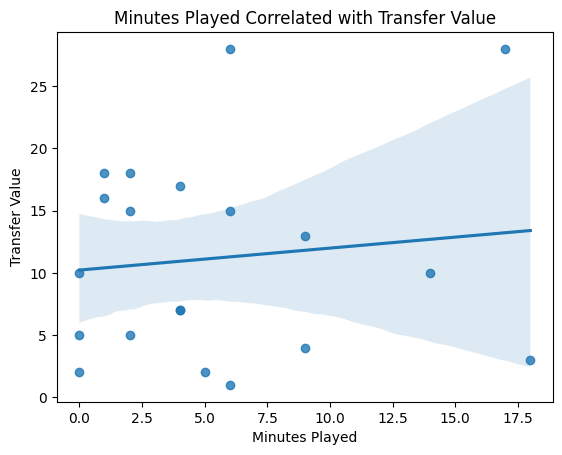

In [47]:
plot = sb.regplot(data=df, x="successful_take_ons", y="price")





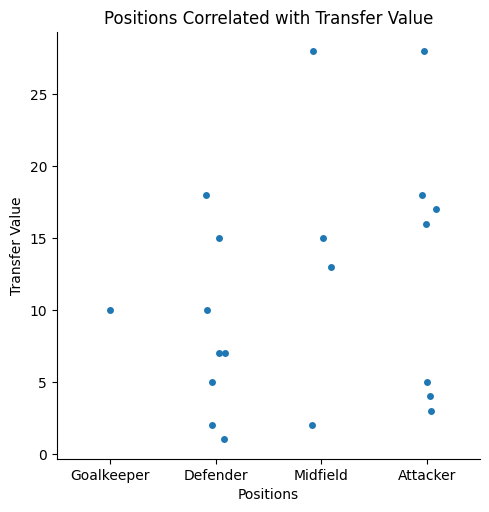

In [65]:
plot = sb.catplot(data=df, x="position", y="price", order=["Goalkeeper", "Defender", "Midfield", "Attacker"])

plot.set(xlabel ="Positions", ylabel = "Transfer Value", title ='Positions Correlated with Transfer Value')
plt.show()

In [66]:
df.count()

Player                 20
minutes_played         20
matches_played         20
matches_started        20
tackles                20
                       ..
height                 20
foot                   20
join_date              20
contract_expiration    20
ratio                  20
Length: 85, dtype: int64

In [60]:
df.position = df.position.replace('Attacking Midfield', 'Midfield')


